## Train QuickNAT
Working code! Details coming soon!

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from networks.quickNAT import quickNAT
from networks.data_utils import get_imdb_data

#torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#%load_ext autoreload
#%autoreload 2
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [9]:
%reset -f
#train_data, test_data = get_imdb_data()
#print("Train size: %i" % len(train_data))
#print("Test size: %i" % len(test_data))

In [ ]:
from networks.quickNAT import quickNAT
from networks.solver import Solver

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=4)

param ={
        'num_channels':1,
        'num_filters':64,
        'kernel_h':5,
        'kernel_w':5,
        'kernel_c': 1,
        'stride_conv':1,
        'pool':2,
        'stride_pool':2,
        'num_class':28
    }

exp_dir_name = 'Exp01_try'

quicknat_model = quickNAT(param)
solver = Solver(optim_args={"lr": 1e-2})
solver.train(quicknat_model, train_loader, val_loader, log_nth=10, num_epochs=10, exp_dir_name=exp_dir_name)


## Save the Model

When you are satisfied with your training, you can save the model.

In [106]:
quicknat_model.save("models/quicknat_model.model")

Saving model... models/relaynet_good.model


# Deploy Model on Test Data

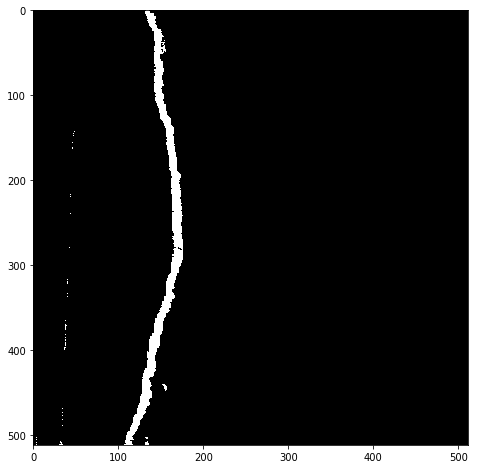

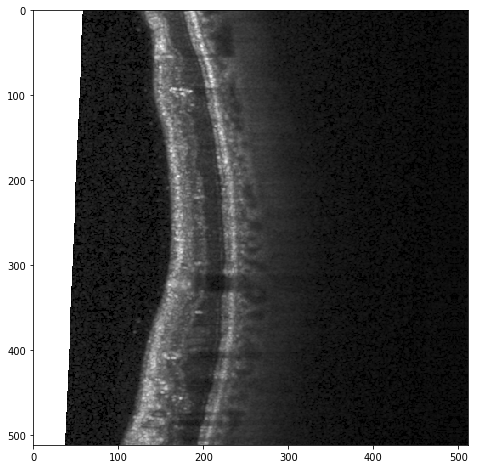

In [6]:
import matplotlib.pyplot as plt

out = quicknat_model(Variable(torch.Tensor(test_data.X[11:12]).cuda(),volatile=True))
max_val, idx = torch.max(out,1)
idx = idx.data.cpu().numpy()
idx = np.squeeze(idx==2)
plt.imshow(idx)
plt.show()

img_test = test_data.X[11:12]
img_test = np.squeeze(img_test)
plt.imshow(img_test)
plt.show()